In [1]:
import numpy as np, pandas as pd, scipy.stats as ss, seaborn as sns, os
from matplotlib import pyplot as plt
%matplotlib inline
np.random.seed(71191)

def allelic_ANOVA(site, pheno):
    """
    This regression is equivalent to one-way ANOVA with 2 groups. 
    Return F-statistic.
    Assumes site is coded as -1, 1
    """
    coding = np.array(site, np.float)
    pheno = np.array(pheno, np.float)
    
    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F


def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [2]:
paul = pd.read_csv('/home/croth/Downloads/melanin_measurements_paul.csv')
paul = paul[(paul.strain!='H99')]

In [3]:
paul[(paul.strain=='SS-A837')]

,row,column,plate,strain,replicate,day,mean_grey,background_grey,melanin_binary
155,e,7,qtl2,SS-A837,1,3,62.436,110.928,1.0
215,e,7,qtl2,SS-A837,2,3,108.336,97.312,1.0


In [4]:
pwd

'/home/croth'

In [5]:
gv = pd.read_csv('./CDx-ill-SNP-INDEL-df-104-blocked.csv.gz')
segs = np.array([s 
                 for s in paul.strain.unique() 
                 if s in gv.columns])
print(segs.shape)

loci = gv.Block.drop_duplicates().index
print(loci.shape)

(104,)
(3108,)


In [6]:
debra =pd.read_csv('/home/croth/Downloads/L-DOPA-July32019.csv')
debra = debra[(debra.strain!='H99')]
debra.dropna(inplace=True,axis=0,how='any')
debra['Mean'] = debra['Mean'].astype(float)

In [7]:
debra.shape

(1080, 17)

In [8]:
dm_mean = pd.DataFrame([list(a[0])+list(
    [a[1]['row'].unique()[0],a[1]['column'].unique()[0],
     a[1]['Mean'].mean()]) 
 for a in debra.groupby(['plate','strain'])],
                       columns=['plate','strain',
                                'row','column','Mean'])

In [9]:
pm_dm = paul[(paul.replicate==1)][[
    'plate','strain','mean_grey']].merge(dm_mean)

In [10]:
pm1_dm2 = dm_mean[(dm_mean.plate=='qtl2')].merge(
    paul[(paul.replicate==1) & (paul.plate=='qtl1')][
        ['row','column','mean_grey']]);
pm2_dm1 = dm_mean[(dm_mean.plate=='qtl1')].merge(
    paul[(paul.replicate==1) & (paul.plate=='qtl2')][
        ['row','column','mean_grey']]);

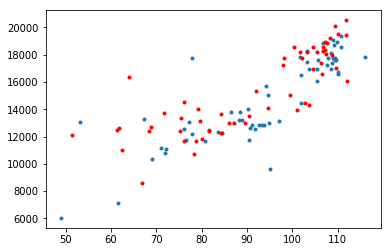

In [11]:
plt.plot(pm1_dm2.mean_grey,pm1_dm2.Mean.values,'.');
plt.plot(pm2_dm1.mean_grey,pm2_dm1.Mean.values,'r.');

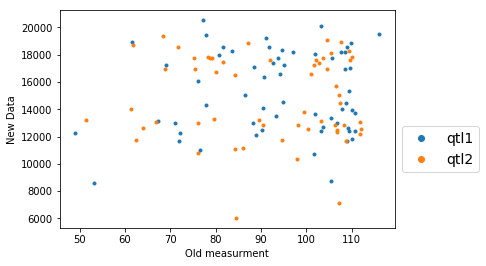

In [12]:
[plt.plot(pm_dm[(pm_dm.plate==p)].mean_grey.values,
          pm_dm[(pm_dm.plate==p)].Mean.values,'.',label=p) 
 for p in ['qtl1','qtl2']];
plt.legend(fontsize=14,markerscale=2,
           bbox_to_anchor=(1,0.5));
plt.xlabel('Old measurment');
plt.ylabel('New Data');

In [13]:
debra['Rep'] = [a[-1] for a in debra['rep'].tolist()]

In [14]:
debra['Nrep']= debra['Rep'].replace(dict(zip(['a','b','c'],np.arange(3))))

In [15]:
debra['Nrep'].unique()

array([0, 1, 2])

In [16]:
debra['Nmea'] = [int(a[-1])-1 for a in debra['measurement']]

In [17]:
debra.Nmea.unique()

array([0, 1, 2])

In [18]:
titles = np.concatenate(np.array([('Matched','Switched') 
                         for i in range(3)]))

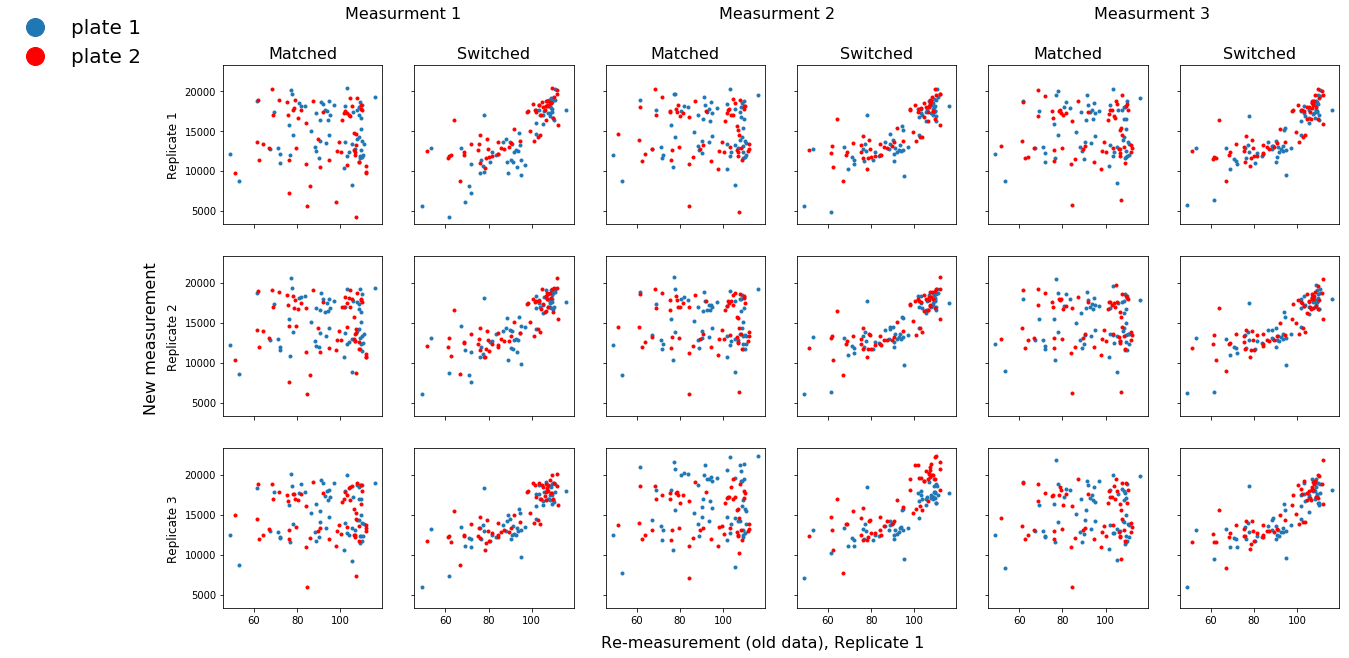

In [19]:
R = 1
pm_r1p1 = paul[(paul.plate=='qtl1') & (paul.replicate==R)]
pm_r1p2 = paul[(paul.plate=='qtl2') & (paul.replicate==R)]
fig,ax= plt.subplots(3,6,figsize=(20,10),sharey=True,sharex=True)
for r in debra.Nrep.unique():
    for m in debra.Nmea.unique():
        if m == 0:
            plt.sca(ax[r,m])
            plt.ylabel('Replicate %s'%(r+1),fontsize=12)
        
        dm_q1 = debra[(debra.plate=='qtl1') & 
                (debra.Nrep==r) & 
                (debra.Nmea==m)]

        dm_q2 = debra[(debra.plate=='qtl2') & 
                (debra.Nrep==r) & 
                (debra.Nmea==m)]
        ## H0 no switch
        test_p1 = pm_r1p1.merge(dm_q1,on=['row','column'])
        test_p2 = pm_r1p2.merge(dm_q2,on=['row','column'])
        ## H1 there is a switch
        switch_p1 = pm_r1p1.merge(dm_q2,on=['row','column'])
        switch_p2 = pm_r1p2.merge(dm_q1,on=['row','column'])

        plt.sca(ax[r,2*m])
        plt.plot(test_p1.mean_grey.values,
                 test_p1.Mean.values,'.',
                label = 'plate 1' if (r+m == 0) else None);
        plt.plot(test_p2.mean_grey.values,
                 test_p2.Mean.values,'r.',
                label = 'plate 2' if (r+m == 0) else None);
        plt.sca(ax[r,(1+(2*m))])
        plt.plot(switch_p1.mean_grey.values,
                 switch_p1.Mean.values,'.',);
        plt.plot(switch_p2.mean_grey,switch_p2.Mean,'r.');
fig.text(0.5,0.07,'Re-measurement (old data), Replicate %s'%(R),
         fontsize=16,ha='center');
fig.text(0.07,0.5,'New measurement',
         rotation=90,va='center',fontsize=16);
for i in range(6):
    plt.sca(ax[0,i])
    plt.title(titles[i],fontsize=16);
    
for i in range(3):
    fig.text(0.25+(0.26*i),.95,'Measurment %s'%(i+1),
             fontsize=16,va='center',ha='center');
plt.sca(ax[0,0])
plt.legend(bbox_to_anchor=(-0.4,1.4),
           frameon=False,fontsize=20,markerscale=6)
plt.savefig('Melanin_Reanalysis_oldrep_%s.png'%(R),
            bbox_inches='tight',dpi=100);

In [20]:
ps1 = pd.DataFrame([(s[0],s[1]['row'].unique()[0],
                     s[1]['column'].unique()[0],
                     np.mean([r[1]['Mean'].median() 
                 for  r in s[1].groupby('rep')])) 
        for s in 
        debra[(debra.plate=='qtl1')].groupby(['strain'])],
                  columns=['oldstrain','row','column','Melanin'])
ps1['plate'] = 1
ps2 = pd.DataFrame([(s[0],s[1]['row'].unique()[0],
                     s[1]['column'].unique()[0],
                     np.mean([r[1]['Mean'].median() 
                 for  r in s[1].groupby('rep')])) 
        for s in 
        debra[(debra.plate=='qtl2')].groupby(['strain'])],
                  columns=['oldstrain','row','column','Melanin'])
ps2['plate'] = 2

In [21]:
ps1u = ps1.merge(paul[(paul.plate=='qtl2')&(paul.replicate==1)][
    ['row','column','strain']])
ps2u = ps2.merge(paul[(paul.plate=='qtl1')&(paul.replicate==1)][
    ['row','column','strain']])

In [22]:
ps1u.shape

(60, 6)

In [23]:
ps2u.head()

,oldstrain,row,column,Melanin,plate,strain
0,SS-A837,e,7.0,11752.092667,2,SS-B869_cor
1,SS-B307,b,2.0,17455.744000,2,SS-B357
2,SS-B308,b,3.0,13758.783333,2,SS-B360
3,SS-B310,b,4.0,5925.816000,2,SS-B364
4,SS-B311,b,5.0,17842.346000,2,SS-B366


In [24]:
ps = pd.concat([ps1u,ps2u])
ps.index = ps.strain

In [25]:
ps.head()

,oldstrain,row,column,Melanin,plate,strain
strain,,,,,,
SS-B307,SS-B357,b,2.0,12310.311000,1,SS-B307
SS-B308,SS-B360,b,3.0,15060.323333,1,SS-B308
SS-B310,SS-B364,b,4.0,12255.142667,1,SS-B310
SS-B311,SS-B366,b,5.0,14045.272333,1,SS-B311
SS-B312,SS-B368,b,6.0,18635.336333,1,SS-B312


In [26]:
r1 = paul[(paul.replicate==1)][
    ['strain','mean_grey']]
r1.index = r1['strain']

In [27]:
dup_str = [s for s 
           in ps.strain.tolist() if 
           ps[(ps.strain==s)].shape[0]>1]

In [28]:
dup_str

['SS-B575', 'SS-B575']

In [29]:
ps[(ps.strain.isin(dup_str))]

,oldstrain,row,column,Melanin,plate,strain
strain,,,,,,
SS-B575,SS-B563,c,8.0,12883.338667,1,SS-B575
SS-B575,SS-B908,g,2.0,13672.842333,2,SS-B575


In [30]:
ps[(ps.strain=='SS-A837')]

,oldstrain,row,column,Melanin,plate,strain
strain,,,,,,
SS-A837,SS-B869_cor,e,7.0,11169.802,1,SS-A837


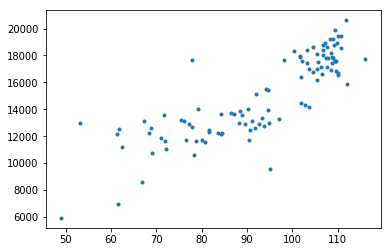

In [31]:
## Check our work
plt.plot(r1.T[segs].T['mean_grey'],ps.T[segs].T['Melanin'],'.');

In [32]:
ps.reset_index(drop=True,inplace=True)
melanin = ps.groupby('strain').aggregate('mean')

In [33]:
ps.head()

,oldstrain,row,column,Melanin,plate,strain
0,SS-B357,b,2.0,12310.311000,1,SS-B307
1,SS-B360,b,3.0,15060.323333,1,SS-B308
2,SS-B364,b,4.0,12255.142667,1,SS-B310
3,SS-B366,b,5.0,14045.272333,1,SS-B311
4,SS-B368,b,6.0,18635.336333,1,SS-B312


In [34]:
ps.shape

(120, 6)

In [35]:
ps[['row','column','Melanin','plate','strain']].to_csv(
    '/home/croth/Desktop/Cdx_melanin.csv',index=None)

In [36]:
melanin.to_csv('/home/croth/Desktop/Cdx_melanin_cor.csv',index=True)

In [37]:
melanin.head()

,column,Melanin,plate
strain,,,
SS-A837,7.0,11169.802000,1.0
SS-B307,2.0,12310.311000,1.0
SS-B308,3.0,15060.323333,1.0
SS-B310,4.0,12255.142667,1.0
SS-B311,5.0,14045.272333,1.0


In [38]:
#pval=gv.loc[loci][segs].apply(
#                association_logPval,
#                args=[melanin['Melanin'][segs]],axis=1)


test = gv[segs].drop_duplicates()
test['Melanin'] = test.apply(association_logPval,args=[melanin['Melanin'][segs]],axis=1)
pval_df = gv.merge(test)

In [39]:
nperms = 10000
perm_path = './Melanin_MI_QTL_perms_%s.csv'%(nperms)
if os.path.exists(perm_path):
    perms = np.concatenate(
        pd.read_csv(perm_path,header=None).values)
else:
    perms = []
    for i in range(nperms):
        pheno = pd.Series(np.random.permutation(melanin['Melanin'][segs]),
                          index=segs)
        
        maxpval = np.max(gv.loc[loci][segs].apply(
                    association_logPval,args=[pheno[segs]],axis=1))
        
        perms.append(maxpval)
        
    open(perm_path,'w'
        ).writelines('\n'.join(np.array(perms,dtype='str')))
    perms = np.array(perms)

In [40]:
perms.shape

(10000,)

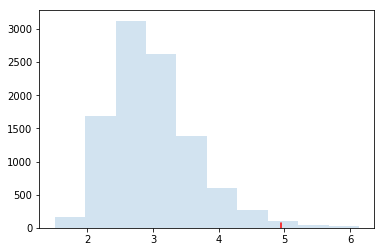

In [41]:
plt.hist(perms,alpha=0.2);
plt.vlines(np.percentile(perms,99),
           0,len(perms)/100,linestyle='--',color='r');

In [42]:
np.percentile(perms,99)

4.943289325453206

In [43]:
np.percentile(perms,95)

4.202101792341655

In [44]:
#pval_df = gv.T[loci].T[['Chrom','Pos']]
#pval_df['Melanin'] = pval
#pval_df.head()

In [45]:
chrlist = sorted(pval_df.Chrom.unique())
chrlens = np.array([pval_df[(pval_df.Chrom==c)].Pos.max() 
           for c in chrlist])
cumpos = np.array([0] + list(np.cumsum(chrlens[:-1])))
cummax = cumpos[-1] + pval_df[(pval_df.Chrom=='Chr14')].Pos.max()
chrmid = (chrlens/2) + cumpos

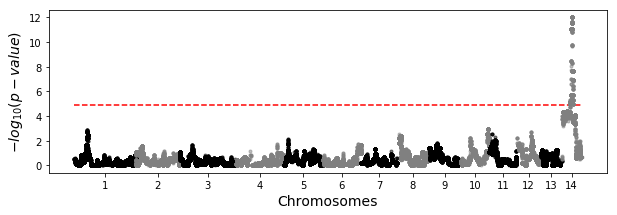

In [46]:
fig,ax = plt.subplots(1,1,figsize=(10,3));
for c in chrlist:
    i = int(c[3:])-1
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos+cumpos[i],temp['Melanin'],'.',
             color='k' if i%2==0 else 'grey',
             alpha = 0.5)
plt.xticks(chrmid,np.arange(len(chrlist))+1);
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosomes',fontsize=14);
plt.hlines(4.93,0,temp.Pos.max()+np.max(cumpos),linestyles='--',color='r')
plt.savefig('./Melanin_Manhattan_switched.png',
           dpi=150,bbox_inches='tight');

In [47]:
pval_df.to_csv('./Melanin_QTL_pvalues.csv',index=True)

In [101]:
pval_df

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382,Melanin,HTG
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.543471,0.020092
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.543471,0.020092
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.543471,0.020092
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.543471,0.020092
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.543471,0.020092
5,Chr01,6401,125385.0,1.0,G,A,1,10036,snp,315,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.543471,0.020092
6,Chr01,6477,115876.0,1.0,T,C,1,9211,snp,317,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.543471,0.020092
7,Chr01,6903,96289.3,1.0,A,G,1,7946,snp,322,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.543471,0.020092
8,Chr01,7291,98076.7,1.0,AA,GA,1,8537,indel,342,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.543471,0.020092
9,Chr01,7340,109106.0,1.0,A,G,1,9233,snp,349,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.543471,0.020092


In [48]:
qtlix = pval_df['Melanin'].idxmax()

In [49]:
qtlix

90495

In [50]:
qtlplot = pd.DataFrame([gv.T[qtlix].T[segs],melanin.T[segs].T['Melanin']]).T
qtlplot.columns = ['QTL','Melanin']
#qtlplot['LMelanin'] = 1/np.log10(qtlplot.Melanin.values)

In [51]:
qtlplot.T[['XL280a','XL280alpha','SS-A837']].T[['QTL','Melanin']]

,QTL,Melanin
strain,,
XL280a,0.0,18894.701000
XL280alpha,0.0,19862.037333
SS-A837,1.0,11169.802000


In [52]:
qtlplot.to_csv('~/Melanin_Phenotypes.csv',index=True)

In [53]:
from matplotlib.gridspec import GridSpec
import statsmodels.formula.api as smf

In [54]:
mod = smf.ols(formula='Melanin~QTL', data=qtlplot)
res = mod.fit()

In [55]:
res.rsquared

0.3946542204641629

In [56]:
qtlsgv = pd.read_csv('/home/croth/Downloads/Cdx-QTL-gvs.csv',index_col=0)

In [57]:
qtlsgv.head()

,15560,75313,82942,90473
SS-B407,1.0,0.0,1.0,0.0
SS-B316,0.0,1.0,1.0,1.0
SS-B898_cor,0.0,0.0,0.0,1.0
SS-B369,0.0,0.0,1.0,0.0
SS-B997,1.0,1.0,1.0,0.0


In [58]:
qtlplot[gv.T[np.array(qtlsgv.columns.values,dtype=int)].T['Chrom'].tolist()] = qtlsgv.T[qtlplot.index].T

In [59]:
qtlplot[['QTL','Chr14']].diff(axis=1)['Chr14'].sum()

1.0

In [60]:
qtlplot.head()

,QTL,Melanin,Chr02,Chr11,Chr12,Chr14
strain,,,,,,
SS-B357,0.0,17455.744000,1.0,0.0,1.0,0.0
SS-B360,1.0,13758.783333,0.0,0.0,0.0,1.0
SS-B364,0.0,5925.816000,0.0,1.0,0.0,0.0
SS-B366,0.0,17842.346000,1.0,0.0,1.0,0.0
SS-B368,0.0,19223.485333,1.0,0.0,0.0,0.0


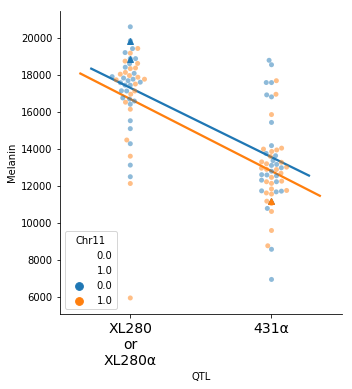

In [61]:
sns.lmplot(x='QTL',y='Melanin',data = qtlplot,x_jitter=0.2,ci=True,hue='Chr11',
           scatter_kws={'color':'k','alpha':0.0},legend_out=False,legend=False)
            #line_kws={'color':'r','alpha':0.25})
sns.swarmplot(x='QTL',y='Melanin',data=qtlplot,alpha=0.5,hue='Chr11')
plt.plot(*qtlplot.T[['XL280a','XL280alpha','SS-A837']].T[['QTL','Melanin']].T.values,
         '^',color='tab:blue',ms=6)
plt.plot(*qtlplot.T['SS-A837'].T[['QTL','Melanin']].T.values,
         '^',color='tab:orange',ms=6)
plt.xticks([0,1],['XL280\nor\nXL280'+'\u03B1','431'+'\u03B1'],fontsize=14);

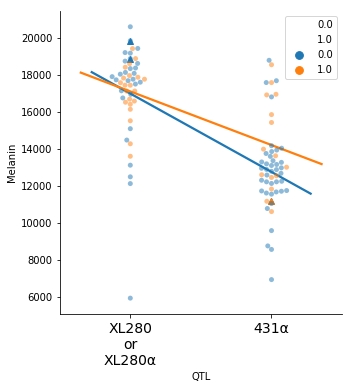

In [62]:
sns.lmplot(x='QTL',y='Melanin',data = qtlplot,x_jitter=0.2,ci=True,hue='Chr12',
           scatter_kws={'color':'k','alpha':0.0},legend_out=False,legend=False)
            #line_kws={'color':'r','alpha':0.25})
sns.swarmplot(x='QTL',y='Melanin',data=qtlplot,alpha=0.5,hue='Chr12')
plt.legend()
plt.plot(*qtlplot.T[['XL280a','XL280alpha','SS-A837']].T[['QTL','Melanin']].T.values,
         '^',color='tab:blue',ms=6)
plt.plot(*qtlplot.T['SS-A837'].T[['QTL','Melanin']].T.values,
         '^',color='tab:orange',ms=6)
plt.xticks([0,1],['XL280\nor\nXL280'+'\u03B1','431'+'\u03B1'],fontsize=14);

In [63]:
qtlplot.groupby(['QTL','Chr12']).count()['Melanin']

QTL  Chr12
0.0  0.0      28
     1.0      21
1.0  0.0      40
     1.0      15
Name: Melanin, dtype: int64

In [64]:
qtlplot['Chr12'].sum()/qtlplot.shape[0]

0.34615384615384615

In [65]:
smf.ols('Melanin~QTL + Chr12',data=qtlplot).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Melanin   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     34.76
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           3.26e-12
Time:                        14:51:38   Log-Likelihood:                -956.28
No. Observations:                 104   AIC:                             1919.
Df Residuals:                     101   BIC:                             1926.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.673e+04    407.668     41.039      0.000    1.59e+04    1.75e+04
QTL        -3779.1766    481.475     -7.849      0.000   -4734.293   -2824.060
Chr12        753.5638    505.181      1.492      0.139    -248.580    1755.707
==============================================================================
Omnibus:                       24.605   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.444
Skew:                          -0.835   Prob(JB):                     7.50e-14
Kurtosis:                       6.340   Cond. No.                         3.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

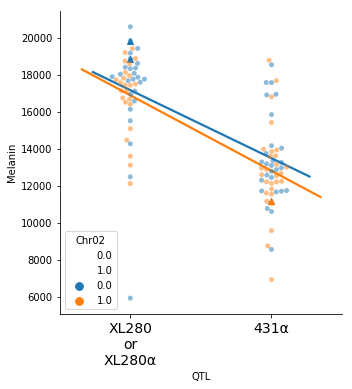

In [66]:
sns.lmplot(x='QTL',y='Melanin',data = qtlplot,x_jitter=0.2,ci=True,hue='Chr02',
           scatter_kws={'color':'k','alpha':0.0},legend_out=False,legend=False)
            #line_kws={'color':'r','alpha':0.25})
sns.swarmplot(x='QTL',y='Melanin',data=qtlplot,alpha=0.5,hue='Chr02')
plt.plot(*qtlplot.T[['XL280a','XL280alpha','SS-A837']].T[['QTL','Melanin']].T.values,
         '^',color='tab:blue',ms=6)
plt.plot(*qtlplot.T['SS-A837'].T[['QTL','Melanin']].T.values,
         '^',color='tab:orange',ms=6)
plt.xticks([0,1],['XL280\nor\nXL280'+'\u03B1','431'+'\u03B1'],fontsize=14);

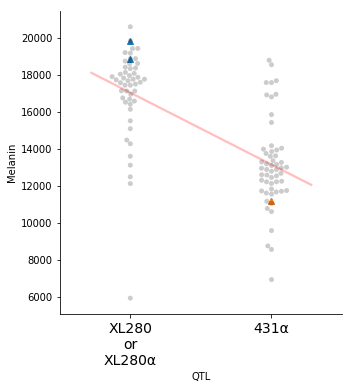

In [67]:
sns.lmplot(x='QTL',y='Melanin',data = qtlplot,x_jitter=0.2,ci=False,
           scatter_kws={'color':'k','alpha':0.0},
            line_kws={'color':'r','alpha':0.25})
sns.swarmplot(x='QTL',y='Melanin',data=qtlplot,alpha=0.2,color='k')
plt.plot(*qtlplot.T[['XL280a','XL280alpha','SS-A837']].T[['QTL','Melanin']].T.values,
         '^',color='tab:blue',ms=6)
plt.plot(*qtlplot.T['SS-A837'].T[['QTL','Melanin']].T.values,
         '^',color='tab:orange',ms=6)
plt.xticks([0,1],['XL280\nor\nXL280'+'\u03B1','431'+'\u03B1'],fontsize=14);

In [68]:
#strain_n = strain_temp[:3]+['XL280'+'\u03B1','XL280'+ r'$\bf{a}$','431'+'\u03B1']+[strain_temp[-1]]

In [69]:
from PIL import Image

In [70]:
#sns.set(style='ticks',context='talk')
plt.style.use(['tableau-colorblind10'])
#sns.set(font_scale=1)
#sns.set(style='ticks',context='talk')

In [71]:
## Amphotericin B and thermal tolerance
## Set phenotype data path
file_path = '/home/croth/Desktop/Tecan_qtlruns_Jan162019_curated_baselined_median51.csv'
## Bring in phenotype data
df = pd.read_csv(file_path,index_col=0)
dfcol = df.columns.tolist()
time_ix = dfcol.index('6300s')
times_ixs = dfcol[time_ix:]
#df.index = df.strain
df = df[(df.strain.isin(gv.columns)) & (df.temp!=38)]
timex = [np.round(int(a[:-1])/(60**2),3) for a in times_ixs]
dx = np.max(np.diff(timex))
df.index = df.strain
df.drop('strain',inplace=True,axis=1)
df['AUC'] = df[times_ixs].sum(axis=1)*dx
df.head()

htg = df[(df.temp==39) & (df.amphB==0.0)][times_ixs]

In [72]:
assert df.index.unique().shape[0] == len(segs)

In [73]:
auc = htg.sum(axis=1).groupby(htg.index).median()*dx

In [74]:
test['HTG'] = test[segs].apply(association_logPval,args=[auc[segs].values],axis=1)
pval_df = pval_df.merge(test)

In [75]:
pval_df.shape

(92103, 127)

In [76]:
def myminmax(x):
    x = np.array(x)
    return (x-x.min())/(x.max()-x.min())

In [77]:
melanin['HTG'] = auc[melanin.index]

In [78]:
ch14 = pval_df[(pval_df.Chrom=='Chr14')]
kb = 1000

In [79]:
melanin.dropna(inplace=True)

In [80]:
melanin['QTL14'] = ch14.T[ch14.Melanin.idxmax()].T[melanin.index].apply(int)

In [81]:
pval_df.Melanin.max()

12.025542499656044

In [82]:
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']

In [83]:
results = smf.ols('Melanin~QTL',data=qtlplot).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Melanin   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     66.50
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           9.43e-13
Time:                        14:51:41   Log-Likelihood:                -957.41
No. Observations:                 104   AIC:                             1919.
Df Residuals:                     102   BIC:                             1924.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.705e+04    347.493     49.075      0.000    1.64e+04    1.77e+04
QTL        -3896.6151    477.838     -8.155      0.000   -4844.405   -2948.825
==============================================================================
Omnibus:                       27.834   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.433
Skew:                          -0.916   Prob(JB):                     4.17e-17
Kurtosis:                       6.749   Cond. No.                         2.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
mel_r_sq = np.round(results.rsquared,2)

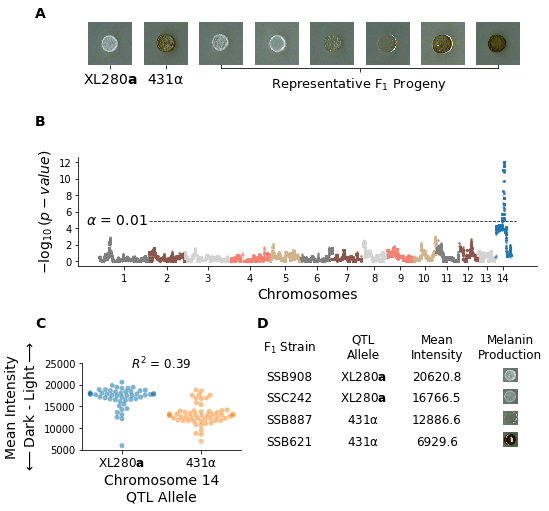

In [85]:
fig = plt.figure(figsize=(11,2))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, :-1])


plt.sca(ax0)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
for c in chrlist:
    i = int(c[3:])-1
    if c == 'Chr14':
        cc = 'tab:blue'
    else:
        cc = chrom_colors[i%len(chrom_colors)]
   
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos+cumpos[i],temp['Melanin'].values,'.',
             alpha = 0.25,markersize=3,color=cc)
    
plt.xticks(chrmid,np.arange(len(chrlist))+1);
#plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);

plt.xlabel('Chromosomes',fontsize=14);
plt.yticks(np.arange(0,16,2))
plt.hlines(4.93,chrlens[0],19.1*(10**6),
           linestyles='dashed',color='k',
           ##label='\u03B1 = 0.01',
           alpha=0.9,linewidth=.8);

plt.text(s = r'$\alpha$ = 0.01', x = 0.085,y= .42, 
         horizontalalignment='center',
         verticalalignment='center', 
         transform=ax0.transAxes, fontsize=14 )

plt.subplots_adjust(wspace=0.05)

plt.sca(ax0)
axs = fig.add_axes([0.305,1.50,.35,.1])
plt.xticks([0.5],labels=['Representative F$_1$ Progeny'],
           fontsize=13)
plt.yticks([ ],labels=None)
axs.spines['top'].set_visible(False) 


## Plot xl280a
plt.sca(ax0)
axm = fig.add_axes([0.09,1.52,0.15,.3])
xl280a_path = './XL280a_LDOPA_day3_middle.png'
xl280a_obj = Image.open(xl280a_path)
plt.imshow(xl280a_obj),# aspect='auto')
plt.xticks([40],labels=['XL280'+ r'$\bf{a}$'],fontsize=14)
plt.yticks([]);
[axm.spines[a].set_visible(False) 
 for a in ['top','bottom','left','right']]

## Plot 431
plt.sca(ax0)
axm = fig.add_axes([0.16,1.52,0.15,.3])
plt.yticks([]);
A837_path = './SSA837_LDOPA_day3_middle.png'
A837_obj = Image.open(A837_path)
plt.imshow(A837_obj),# aspect='auto')
plt.xticks([40],labels=['431'+'$\mathrm{\u03B1}$'],fontsize=14)
[axm.spines[a].set_visible(False) 
 for a in ['top','bottom','left','right']]


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.23,1.52,0.15,.3])
plt.yticks([]);
spath = './S2_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.30,1.52,0.15,.3])
plt.yticks([]);
spath = './S6_LDOPA_day3_middle.png' #'./S1_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.37,1.52,0.15,.3])
plt.yticks([]);
spath = './S1_LDOPA_day3_middle.png'#'./S3_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.44,1.52,0.15,.3])
plt.yticks([]);
spath = './S3_LDOPA_day3_middle.png'#'./S4_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.51,1.52,0.15,.3])
plt.yticks([]);
spath = './S5_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.58,1.52,0.15,.3])
plt.yticks([]);
spath = './S4_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')



#### ------------------------------------------------------------ #####

plt.sca(ax0)
axl =  fig.add_axes([0.13,-1.15, 0.2,.6])
plt.sca(axl)

axl.spines['right'].set_visible(False)
axl.spines['top'].set_visible(False)
#plt.plot([0,0.5],[lightest,ymax],'k-',alpha=0.8,linewidth=2)

sns.swarmplot(x='QTL14',y='Melanin',data=melanin,alpha=0.5,ax=axl)

ymax = 25000
ymin = 5000
plt.ylim(ymin,ymax)
xl280_name = 'XL280'+r'$\bf{a}$'
_431_name = '431'+u'$\mathrm{\u03B1}$'
plt.text(0.5,25000,'$R^2$ = %s'%mel_r_sq,fontsize=12,ha='center',va='center')
plt.xticks([0,1],[xl280_name,_431_name],fontsize=12)
plt.xlabel('Chromosome 14\nQTL Allele',fontsize=14)


xl280strains = melanin[(melanin.QTL14==0)].sort_values('Melanin').index.tolist()
_431strains = melanin[(melanin.QTL14==1)].sort_values('Melanin').index.tolist()

lightest = xl280strains[-1]
darkest = _431strains[0]
xlmid = xl280strains[:(int(len(xl280a_path)/2))][-1]
_431mid = _431strains[:(int(len(_431strains)/2))][-1]
plt.ylabel('Mean Intensity\n$\longleftarrow$Dark - Light$\longrightarrow$',fontsize=14);

plt.sca(axl)
#plt.plot([0,0.5],[lightest,ymax],'k-',alpha=0.8,linewidth=2)

fig.text(0.07,1.85,'A',fontsize=14,fontweight='bold')
fig.text(0.07,1.1,'B',fontsize=14,fontweight='bold')
fig.text(0.07,-0.3,'C',fontsize=14,fontweight='bold')
fig.text(0.35,-0.3,'D',fontsize=14,fontweight='bold')



axr =  fig.add_axes([0.36,-1.1, 0.32,.6])

to_plot = melanin.T[[lightest,darkest,xlmid,_431mid]].T.sort_values('Melanin')[::-1]

[plt.text(0.1+(0.29*i),1.1,s=k, transform=axr.transAxes,fontsize=12,va='center',ha='center') 
 for i,k in enumerate(['F$_1$ Strain','QTL\nAllele','Mean\nIntensity','Melanin\nProduction'])]

[plt.text(0.1,0.01+(0.25*i),s=''.join(k.split('-')), 
          transform=axr.transAxes,fontsize=12,va='center',ha='center') 
 for i,k in enumerate(to_plot.index.tolist()[::-1])]

[plt.text(0.1+(.29),0.01+(0.25*i),s= xl280_name if k == 0 else _431_name, 
          transform=axr.transAxes,fontsize=12,va='center',ha='center') 
 for i,k in enumerate(to_plot.QTL14.tolist()[::-1])]

[plt.text(0.1+(.29)+(.29),0.01+(0.25*i),s= np.round(k,1), 
          transform=axr.transAxes,fontsize=12,va='center',ha='center') 
 for i,k in enumerate(to_plot.Melanin.tolist()[::-1])]

plt.axis('off')
plt.sca(axl)

axm = fig.add_axes([0.62,-1.13 +.45,0.1,0.1])
plt.yticks([]);
k = 'SSB908'
spath = './%s_LDOPA_day3_middle.png'%k
sobj = Image.open(spath)
plt.imshow(sobj)
plt.xticks([],labels=[])
plt.axis('off')

axm = fig.add_axes([0.62,-1.13 +.30,0.1,0.1])
plt.yticks([]);
k = 'SSC242'
spath = './%s_LDOPA_day3_middle.png'%k
sobj = Image.open(spath)
plt.imshow(sobj)
plt.xticks([],labels=[])
plt.axis('off')

axm = fig.add_axes([0.62,-1.13 +.15,0.1,0.1])
plt.yticks([]);
k = 'SSB887'
spath = './%s_LDOPA_day3_middle.png'%k
sobj = Image.open(spath)
plt.imshow(sobj)
plt.xticks([],labels=[])
plt.axis('off')

axm = fig.add_axes([0.62,-1.13,0.1,0.1])
plt.yticks([]);
k = 'SSB621'
spath = './%s_LDOPA_day3_middle.png'%k
sobj = Image.open(spath)
plt.imshow(sobj)
plt.xticks([],labels=[])
plt.axis('off')


plt.savefig('./Melanin_QTL_chromosome14_phenotypes.png',
            dpi=400,bbox_inches='tight');

In [100]:
Light_than_xl280 = melanin.T[segs].T[(melanin.Melanin>melanin.T['XL280a'].Melanin.max())]
Light_than_xl280.shape[0]/len(segs)

/home/croth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.0673076923076923

In [99]:
dark_than_431 = melanin.T[segs].T[(melanin.Melanin<melanin.T['SS-A837'].Melanin.max())]
dark_than_431.shape[0]/len(segs)

/home/croth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.07692307692307693

In [110]:
melanin.shape

(119, 5)

In [111]:
assert len(segs) == 104
melanin.T[segs]

strain,SS-B357,SS-B360,SS-B364,SS-B366,SS-B368,SS-B369,SS-B373,SS-B374,SS-B378,SS-B379,...,SS-B358,SS-B874_cor,SS-B872,SS-B874,SS-B886,SS-B887,SS-B906,SS-B908,SS-B961,SS-B560
column,2,3,4,5,6,7,8,9,10,11,...,8,9,11,3,4,5,11,2,4,11
Melanin,17455.7,13758.8,5925.82,17842.3,19223.5,15529.8,17781.1,9582.72,17887.3,13015.4,...,13197.2,17700.5,13946.2,18053.5,17919.5,12886.6,14180.9,20620.8,19191.8,15864.4
plate,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
HTG,7.97565,10.7751,4.39,3.02237,23.0345,21.8144,15.699,9.10575,14.052,6.99163,...,13.9266,16.688,3.77575,17.5365,18.2976,10.5648,4.21212,19.0724,20.199,19.2081
QTL14,0,1,0,0,0,0,0,1,0,1,...,1,0,1,0,0,1,1,0,0,1


fig = plt.figure(figsize=(12,2.5))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, :-1])


plt.sca(ax0)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
for c in chrlist:
    i = int(c[3:])-1
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos+cumpos[i],temp['Melanin'].values,'.',
             alpha = 0.25,markersize=3)
    
plt.xticks(chrmid,np.arange(len(chrlist))+1);
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosomes',fontsize=14);

plt.hlines(4.93,chrlens[0],19.1*(10**6),
           linestyles='dashed',color='k',
           ##label='\u03B1 = 0.01',
           alpha=0.9,linewidth=1);

plt.text(s = r'$\alpha$ = 0.01', x = 0.085,y= .42, 
         horizontalalignment='center',
         verticalalignment='center', 
         transform=ax0.transAxes, fontsize=14 )

plt.subplots_adjust(wspace=0.05)

plt.sca(ax0)
axs = fig.add_axes([0.305,1.50,.35,.1])
plt.xticks([0.5],labels=['Representative F$_1$ Progeny'],
           fontsize=13)
plt.yticks([ ],labels=None)
axs.spines['top'].set_visible(False) 


## Plot xl280a
plt.sca(ax0)
axm = fig.add_axes([0.09,1.52,0.15,.3])
xl280a_path = './XL280a_LDOPA_day3_middle.png'
xl280a_obj = Image.open(xl280a_path)
plt.imshow(xl280a_obj),# aspect='auto')
plt.xticks([40],labels=['XL280'+ r'$\bf{a}$'],fontsize=14)
plt.yticks([]);
[axm.spines[a].set_visible(False) 
 for a in ['top','bottom','left','right']]

## Plot 431
plt.sca(ax0)
axm = fig.add_axes([0.16,1.52,0.15,.3])
plt.yticks([]);
A837_path = './SSA837_LDOPA_day3_middle.png'
A837_obj = Image.open(A837_path)
plt.imshow(A837_obj),# aspect='auto')
plt.xticks([40],labels=['431'+'$\mathrm{\u03B1}$'],fontsize=14)
[axm.spines[a].set_visible(False) 
 for a in ['top','bottom','left','right']]


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.23,1.52,0.15,.3])
plt.yticks([]);
spath = './S2_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.30,1.52,0.15,.3])
plt.yticks([]);
spath = './S6_LDOPA_day3_middle.png' #'./S1_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.37,1.52,0.15,.3])
plt.yticks([]);
spath = './S1_LDOPA_day3_middle.png'#'./S3_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.44,1.52,0.15,.3])
plt.yticks([]);
spath = './S3_LDOPA_day3_middle.png'#'./S4_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.51,1.52,0.15,.3])
plt.yticks([]);
spath = './S5_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.58,1.52,0.15,.3])
plt.yticks([]);
spath = './S4_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')




plt.sca(ax0)
axl =  fig.add_axes([0.13,-1.3,0.2,.6])
axr = fig.add_axes([0.5,-1.3,0.2,.6])


axl.spines['right'].set_visible(False)
axl.spines['top'].set_visible(False)
axr.spines['right'].set_visible(False)
axr.spines['top'].set_visible(False)


plt.sca(axl)



plt.plot(ch14.Pos/kb, myminmax(ch14.HTG.values),
         'ro',alpha=0.2,markersize=3,label=u'39°C');
plt.plot(ch14.Pos/kb,myminmax(ch14.Melanin.values),
         'ko',alpha=0.2,markersize=3,label='Melanization');

lgnd = plt.legend(fontsize=14,bbox_to_anchor=(1,1.75),title='QTL')#,frameon=False);
lgnd.legendHandles[0]._legmarker.set_markersize(8)
lgnd.legendHandles[1]._legmarker.set_markersize(8)
plt.ylabel("Normalized\n$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosome 14 Coordinates (kb)',fontsize=14)
plt.hlines(-0.01,568029/kb,644419/kb,color='blue');
plt.yticks([]);

#### ------------------------------------------------------------ #####
plt.sca(axr)

#sns.scatterplot(x='HTG',y='Melanin',data=melanin,hue='QTL14',legend=None,alpha=0.5)

plt.plot(melanin[(melanin.index!='XL280a')&(melanin.QTL14==0)].HTG.values,
         melanin[(melanin.index!='XL280a')&(melanin.QTL14==0)].Melanin.values,
         'o',color='tab:blue',alpha=0.3,label='XL280'+r'$\bf{a}$')
plt.plot(melanin[(melanin.index!='SS-A837')&(melanin.QTL14==1)].HTG.values,
         melanin[(melanin.index!='SS-A837')&(melanin.QTL14==1)].Melanin.values,
         'o',color='tab:orange',alpha=0.3,label='431'+u'$\mathrm{\u03B1}$')
plt.plot(melanin[(melanin.index=='XL280a')].HTG.values,
         melanin[(melanin.index=='XL280a')].Melanin.values,
         '^',color='tab:blue',alpha=0.65)
plt.plot(melanin[(melanin.index=='SS-A837')].HTG.values,
         melanin[(melanin.index=='SS-A837')].Melanin.values,
         '^',color='tab:orange',alpha=0.65)
#plt.ylim(5000,22500)
#sns.regplot(x='HTG',y='MI',data=AUCs,
#            scatter_kws={'alpha':0},line_kws={'color':'k'},order=1);
plt.ylabel('Mean Intensity\n$\longleftarrow$Dark - Light$\longrightarrow$',fontsize=14);
plt.xlabel('Growth AUC at 39°C',fontsize=14);
#plt.title('D',fontweight='bold',x=-0.1,y=1.4,fontsize=14)
plt.legend(fontsize=14,bbox_to_anchor=(0.8,1.75),title='Allele')#,frameon=False);
plt.ylim(5000,25000)
plt.xlim(-1,31)

fig.text(0.07,1.8,'A',fontsize=14,fontweight='bold')
fig.text(0.07,1.1,'B',fontsize=14,fontweight='bold')
fig.text(0.07,-0.4,'C',fontsize=14,fontweight='bold')
fig.text(0.45,-0.4,'D',fontsize=14,fontweight='bold')
plt.savefig('./Melanin_QTL_chromosome14_phenotypes.png',
            dpi=400,bbox_inches='tight');

In [ ]:
assert 1 == 0

In [ ]:
fig = plt.figure(figsize=(12,2.5))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, :-1])


plt.sca(ax0)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
for c in chrlist:
    i = int(c[3:])-1
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos+cumpos[i],temp['Melanin'].values,'.',
             #color='k' if i%2==0 else 'grey',
             alpha = 0.5)
plt.xticks(chrmid,np.arange(len(chrlist))+1);
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosomes',fontsize=14);
#plt.title('B',fontsize=14,fontweight='bold',x=-.1,y=1.2)
plt.hlines(4.93,chrlens[0],19.1*(10**6),
           linestyles='dashed',color='k',
           ##label='\u03B1 = 0.01',
           alpha=0.9,linewidth=1);
##plt.hlines(4.2,0,19.1*(10**6),
##           linestyles='dashed',color='k',
##           label='\u03B1 = 0.05',alpha=0.9,linewidth=1);

##plt.legend(bbox_to_anchor=(.3,1.),frameon=True,fontsize=14)
plt.text(s = r'$\alpha$ = 0.01', x = 0.085,y= .42, 
         horizontalalignment='center',
         verticalalignment='center', 
         transform=ax0.transAxes, fontsize=14 )

plt.subplots_adjust(wspace=0.05)

plt.sca(ax0)
axs = fig.add_axes([0.305,1.50,.35,.1])
plt.xticks([0.5],labels=['Representative F$_1$ Progeny'],
           fontsize=13)
plt.yticks([ ],labels=None)
axs.spines['top'].set_visible(False) 


## Plot xl280a
plt.sca(ax0)
axm = fig.add_axes([0.09,1.52,0.15,.3])
xl280a_path = './XL280a_LDOPA_day3_middle.png'
xl280a_obj = Image.open(xl280a_path)
plt.imshow(xl280a_obj),# aspect='auto')
plt.xticks([40],labels=['XL280'+ r'$\bf{a}$'],fontsize=14)
plt.yticks([]);
[axm.spines[a].set_visible(False) 
 for a in ['top','bottom','left','right']]

## Plot 431
plt.sca(ax0)
axm = fig.add_axes([0.16,1.52,0.15,.3])
plt.yticks([]);
A837_path = './SSA837_LDOPA_day3_middle.png'
A837_obj = Image.open(A837_path)
plt.imshow(A837_obj),# aspect='auto')
plt.xticks([40],labels=['431'+'$\mathrm{\u03B1}$'],fontsize=14)
[axm.spines[a].set_visible(False) 
 for a in ['top','bottom','left','right']]


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.23,1.52,0.15,.3])
plt.yticks([]);
spath = './S2_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.30,1.52,0.15,.3])
plt.yticks([]);
spath = './S6_LDOPA_day3_middle.png' #'./S1_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.37,1.52,0.15,.3])
plt.yticks([]);
spath = './S1_LDOPA_day3_middle.png'#'./S3_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.44,1.52,0.15,.3])
plt.yticks([]);
spath = './S3_LDOPA_day3_middle.png'#'./S4_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.51,1.52,0.15,.3])
plt.yticks([]);
spath = './S5_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.58,1.52,0.15,.3])
plt.yticks([]);
spath = './S4_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')




plt.sca(ax0)
axl =  fig.add_axes([0.13,-1.3,0.2,.6])
axr = fig.add_axes([0.5,-1.3,0.2,.6])


axl.spines['right'].set_visible(False)
axl.spines['top'].set_visible(False)
axr.spines['right'].set_visible(False)
axr.spines['top'].set_visible(False)


plt.sca(axl)
plt.plot(ch14auc.Pos/1000,ch14auc.HTG/ch14auc.HTG.max(),
         'ro',alpha=0.5,label=u'39°C');
plt.plot(ch14mel.Pos/1000,ch14mel.Melanin/ch14mel.Melanin.max(),
         'ko',alpha=0.3,label='Melanization');
plt.legend(fontsize=14,bbox_to_anchor=(1,1.75),title='QTL')#,frameon=False);
plt.ylabel("Normalized\n$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosome 14 Coordinates (kb)',fontsize=14)
plt.hlines(-0.01,568029/1000,644419/1000);
plt.yticks([]);
#plt.text(x=600,y=.9,s=r'$\rho$ = 0.94',va='center',ha='center',fontsize=14)
#plt.title('C',fontweight='bold',x=-0.1,y=1.4,fontsize=14)


plt.sca(axr)
plt.plot(aucx[(aucx.Strain!='XL280a')].HTG.values,
         aucx[(aucx.Strain!='XL280a')].MI.values,
         'o',color='tab:blue',alpha=0.5,label='XL280'+r'$\bf{a}$')
plt.plot(auc4[(auc4.Strain!='SS-A837')].HTG.values,
         auc4[(auc4.Strain!='SS-A837')].MI.values,
         'o',color='tab:orange',alpha=0.5,label='431'+u'$\mathrm{\u03B1}$')
plt.plot(aucx[(aucx.Strain=='XL280a')].HTG.values,
         aucx[(aucx.Strain=='XL280a')].MI.values,
         '^',color='tab:blue',alpha=0.5)
plt.plot(auc4[(auc4.Strain=='SS-A837')].HTG.values,
         auc4[(auc4.Strain=='SS-A837')].MI.values,
         '^',color='tab:orange',alpha=0.5)
#plt.ylim(5000,22500)
#sns.regplot(x='HTG',y='MI',data=AUCs,
#            scatter_kws={'alpha':0},line_kws={'color':'k'},order=1);
plt.ylabel('Mean Intensity\n$\longleftarrow$Dark - Light$\longrightarrow$',fontsize=14);
plt.xlabel('Growth AUC at 39°C',fontsize=14);
#plt.title('D',fontweight='bold',x=-0.1,y=1.4,fontsize=14)
plt.legend(fontsize=14,bbox_to_anchor=(0.8,1.75),title='Allele')#,frameon=False);
plt.ylim(5000,25000)
plt.xlim(-1,31)

fig.text(0.07,1.8,'A',fontsize=14,fontweight='bold')
fig.text(0.07,1.1,'B',fontsize=14,fontweight='bold')
fig.text(0.07,-0.4,'C',fontsize=14,fontweight='bold')
fig.text(0.45,-0.4,'D',fontsize=14,fontweight='bold')
plt.savefig('./Melanin_QTL_chromosome14_phenotypes.png',
            dpi=400,bbox_inches='tight');

In [ ]:
assert 1 == 0

In [ ]:
paul[(paul.strain.isin(['SS-B307','SS-']))]

In [ ]:
fig = plt.figure(figsize=(12,2.5))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, :-1])
ax1 = fig.add_subplot(gs[0,-1])
plt.sca(ax1)
sns.regplot(x='QTL',y='Melanin',data = qtlplot,x_jitter=0.2,ci=False,
           scatter_kws={'color':'k','alpha':0.0},
            line_kws={'color':'r','alpha':0.25})
sns.swarmplot(x='QTL',y='Melanin',data=qtlplot,alpha=0.2,color='k')
plt.plot(*qtlplot.T[['XL280a','SS-A837']].T[['QTL','Melanin']].T.values,
         '^',color='tab:blue',ms=6)
plt.plot(*qtlplot.T['SS-A837'].T[['QTL','Melanin']].T.values,
         '^',color='tab:orange',ms=6)
plt.xticks([0,1],['XL280'+ r'$\bf{a}$','431'+'$\mathrm{\u03B1}$'],fontsize=14)
#plt.xticks([0,1],['XL280\nor\nXL280'+'\u03B1','431'+'\u03B1'],fontsize=14)
#fig.text(x=.79,y=0.047,s='a',fontweight='bold',fontsize=14,va='center',ha='center')
plt.xlabel('Allele',fontsize=14)
ax1.yaxis.tick_right()
ax1.yaxis.set_ticks_position('both')
ax1.yaxis.set_label_position("right")
plt.ylabel(' ')
fig.text(s='Mean Intensity\n$\longleftarrow$Light  -  Dark$\longrightarrow$',
          x =.97,y=0.5, fontsize=16,rotation=-90,va='center',ha='center');
#plt.title('Chromosome 14 QTL\nMelanization',fontsize=14)
plt.title('C',fontsize=14,fontweight='bold',x=.01,y=1.2)
plt.text(x=0.5,y=6000,s='$R^2 = %s$'%(np.round(res.rsquared,2)),
         va='center',ha='center',color='tab:red',alpha=0.8)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.ylim(5000,25000)
ax1.tick_params(left=False)

plt.sca(ax0)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
for c in chrlist:
    i = int(c[3:])-1
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos+cumpos[i],temp['Melanin'].values,'.',
             #color='k' if i%2==0 else 'grey',
             alpha = 0.5)
plt.xticks(chrmid,np.arange(len(chrlist))+1);
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosomes',fontsize=14);
plt.title('B',fontsize=14,fontweight='bold',x=.01,y=1.2)
plt.hlines(4.93,0,19.1*(10**6),
           linestyles='dotted',color='k',label='\u03B1 = 0.01',alpha=0.9,linewidth=1);
plt.hlines(4.2,0,19.1*(10**6),
           linestyles='dashed',color='k',label='\u03B1 = 0.05',alpha=0.9,linewidth=1);

#plt.legend(bbox_to_anchor=(0.1,-0.15),frameon=False)
plt.legend(bbox_to_anchor=(.3,1.2),frameon=True,fontsize=14)

plt.subplots_adjust(wspace=0.05)

plt.sca(ax0)
axs = fig.add_axes([0.305,1.50,.35,.1])
plt.xticks([0.5],labels=['Representative F2 Progeny'],fontsize=13)
plt.yticks([ ],labels=None)
axs.spines['top'].set_visible(False) 


## Plot xl280a
plt.sca(ax0)
axm = fig.add_axes([0.09,1.52,0.15,.3])
xl280a_path = './XL280a_LDOPA_day3_middle.png'
xl280a_obj = Image.open(xl280a_path)
plt.imshow(xl280a_obj),# aspect='auto')
plt.xticks([40],labels=['XL280'+ r'$\bf{a}$'],fontsize=14)
plt.yticks([]);
plt.title('A',fontsize=14,fontweight='bold',x=-.05,y=1.2);
[axm.spines[a].set_visible(False) for a in ['top','bottom','left','right']]

## Plot 431
plt.sca(ax0)
axm = fig.add_axes([0.16,1.52,0.15,.3])
plt.yticks([]);
A837_path = './SSA837_LDOPA_day3_middle.png'
A837_obj = Image.open(A837_path)
plt.imshow(A837_obj),# aspect='auto')
plt.xticks([40],labels=['431'+'$\mathrm{\u03B1}$'],fontsize=14)
[axm.spines[a].set_visible(False) for a in ['top','bottom','left','right']]


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.23,1.52,0.15,.3])
plt.yticks([]);
spath = './S2_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.30,1.52,0.15,.3])
plt.yticks([]);
spath = './S6_LDOPA_day3_middle.png' #'./S1_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.37,1.52,0.15,.3])
plt.yticks([]);
spath = './S1_LDOPA_day3_middle.png'#'./S3_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.44,1.52,0.15,.3])
plt.yticks([]);
spath = './S3_LDOPA_day3_middle.png'#'./S4_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.51,1.52,0.15,.3])
plt.yticks([]);
spath = './S5_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.58,1.52,0.15,.3])
plt.yticks([]);
spath = './S4_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

plt.savefig('./Melanin_QTL_chromosome14_phenotypes.png',
            dpi=300,bbox_inches='tight');

In [ ]:
pwd

In [ ]:
from matplotlib import rc

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,3))

plt.sca(ax[0])
plt.plot(ch14auc.Pos/1000,ch14auc.HTG/ch14auc.HTG.max(),
         'ro',alpha=0.5,label=u'39°C');
plt.plot(ch14mel.Pos/1000,ch14mel.Melanin/ch14mel.Melanin.max(),
         'ko',alpha=0.25,label='Melanization');
plt.legend(fontsize=14,bbox_to_anchor=(0.75,1.45),title='QTL');
plt.ylabel("Normalized\n$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosome 14 Coordinates (kb)',fontsize=14)
plt.hlines(-0.01,568029/1000,644419/1000);
plt.yticks([]);
plt.text(x=600,y=.9,s=r'$\rho$ = 0.94',va='center',ha='center',fontsize=14)
plt.title('A',fontweight='bold',x=0,y=1.3,fontsize=16)


plt.sca(ax[1])
plt.plot(aucx.HTG.values,aucx.MI.values,
         'o',color='tab:blue',alpha=0.5,label='XL280'+r'$\bf{a}$')
plt.plot(auc4.HTG.values,auc4.MI.values,
         'o',color='tab:orange',alpha=0.5,label='431'+u'$\mathrm{\u03B1}$')
#plt.ylim(5000,22500)
#sns.regplot(x='HTG',y='MI',data=AUCs,
#            scatter_kws={'alpha':0},line_kws={'color':'k'},order=1);
plt.ylabel('Mean Intensity\n$\longleftarrow$Dark - Light$\longrightarrow$',fontsize=14);
plt.xlabel('Integral of OD at 39°C',fontsize=14);
plt.title('B',fontweight='bold',x=0,y=1.3,fontsize=16)
plt.legend(fontsize=14,bbox_to_anchor=(0.7,1.45),title='Allele');
#fig.text(s=,
#          x =.97,y=0.5, fontsize=16,rotation=-90,va='center',ha='center');




plt.subplots_adjust(wspace=0.4)
plt.savefig('./Cdx_Melanin_Htg_QTL_overlap.png',dpi=150,bbox_inches='tight')

In [ ]:
np.corrcoef(ch14auc.sort_values('Pos').HTG.values,
            ch14mel.sort_values('Pos').Melanin.values)[0][1]

In [ ]:
ss.pearsonr(ch14auc.sort_values('Pos').HTG.values,
            ch14mel.sort_values('Pos').Melanin.values)

In [ ]:
import pandas as pd

In [ ]:
AUCs = pd.read_csv('/home/croth/Desktop/QTL/Cdx_AUC_QTL.csv',index_col=0)

In [ ]:
AUCs.head()

In [ ]:
sns.swarmplot(y='39.0_0.0',x='QTL14',data=AUCs);

In [ ]:
sns.swarmplot(y='30.0_0.125',x='QTL2',data=AUCs);

In [ ]:
AUC_pval = pd.read_csv('/home/croth/Desktop/QTL/Cdx_AUC_pvals.csv',index_col=0)

In [ ]:
AUCs['MI'] = qtlplot['Melanin'][AUCs.index]

In [ ]:
AUCs.T[['SS-A837','XL280a','XL280alpha']]

In [ ]:
AUCs.head()

In [ ]:
sns.regplot(x='39.0_0.0',y='MI',data=AUCs);

In [ ]:
np.corrcoef(*AUCs[['39.0_0.0','MI']].T.values)[0][1]

In [ ]:
temp = AUCs[['39.0_0.0','MI']].copy()
temp.columns = ['htg','MI']
temp['LogMI'] = np.log10(temp.MI)
smf.ols('LogMI~htg',data=temp).fit().summary()

In [ ]:
gff = pd.read_csv('/home/croth/Downloads/xl280genome.gff3.csv.gz',index_col=0)

In [ ]:
ssk2_pos = gff[(gff.gene=='CNL05560') & (gff.type=='gene')][['start','end']].values[0] 

In [ ]:
ssk2_mod = gv[gv.Pos.isin(np.arange(ssk2_pos[0]-1,ssk2_pos[-1],1)) & (gv.Chrom=='Chr12')][segs].mode(axis=0)

In [ ]:
ssk2_mod.dropna(inplace=True)

In [ ]:
qtlplot['ssk2'] = ssk2_mod[qtlplot.index].T

In [ ]:
qtlplot.head()

In [ ]:
cross_info = pd.read_csv('/home/croth/Desktop/QTL/CDx_PB_Ill_Sample_Info.csv',index_col=0)

In [ ]:
segs = [s for s in qtlplot.index if s not in ['SS-A837','XL280a','XL280alpha']]

In [ ]:
qtlplot['Sex'] = cross_info.T[segs].T['Code']

In [ ]:
qtlplot.head()

In [ ]:
qtlplot.groupby(['QTL','Sex']).count()

In [ ]:
sns.lmplot(x='QTL',y='Melanin',hue='ssk2',data=qtlplot,x_jitter=0.2);

In [ ]:
sns.lmplot(x='QTL',y='Melanin',hue='Sex',data=qtlplot,x_jitter=0.2);

In [ ]:
sns.swarmplot(x='QTL',y='Melanin',hue='Sex',data=qtlplot);

In [ ]:
sns.swarmplot(x='QTL',y='Melanin',hue='ssk2',data=qtlplot);

In [ ]:
qtlplot.groupby(['QTL','ssk2']).count()

In [ ]:
ssk2_mod.T.sum()/(ssk2_mod.shape[1])

In [ ]:
ssk2_mod[qtlplot.index].sum().sum()/len(qtlplot.index)

In [ ]:
qtlplot.shape

In [ ]:
qtlplot[(qtlplot.QTL==0) & (qtlplot.ssk2==0)].sort_values('Melanin',ascending=False)

In [ ]:
qtlplot[(qtlplot.QTL==0) & (qtlplot.ssk2==1)].sort_values('Melanin',ascending=False).head()

In [ ]:
pval_df.head()

In [ ]:
AUC_pval['Melanin'] = pval_df['Melanin'].

In [ ]:
AUC_pval.to_csv('/home/croth/Desktop/Cdx_AUC_Melanin_pvals.csv',index=True)

In [ ]:
temp_mel['30.0_0.0'].idxmax()

In [ ]:
temp_mel = AUC_pval[(AUC_pval.Chrom=='Chr14')]
plt.plot(temp_mel.Pos,temp_mel.Melanin/temp_mel.Melanin.max(),'k.');
plt.plot(temp_mel.Pos,temp_mel['30.0_0.0']/temp_mel['30.0_0.0'].max(),'b.');
plt.vlines(temp_mel.T[temp_mel['Melanin'].idxmax()].Pos,0,1,color='k');
plt.vlines(temp_mel.T[temp_mel['30.0_0.0'].idxmax()].Pos,0,1,color='b');

In [ ]:
temp_mel = AUC_pval[(AUC_pval.Chrom=='Chr14')]
plt.plot(temp_mel.Pos,temp_mel.Melanin/temp_mel.Melanin.max(),'k.');
plt.plot(temp_mel.Pos,temp_mel['39.0_0.075']/temp_mel['39.0_0.075'].max(),'.',color='tab:orange');
plt.vlines(temp_mel.T[temp_mel['Melanin'].idxmax()].Pos,0,1,color='k');
plt.vlines(temp_mel.T[temp_mel['39.0_0.075'].idxmax()].Pos,0,1,color='tab:orange');

In [ ]:
temp_mel = AUC_pval[(AUC_pval.Chrom=='Chr14')]
plt.plot(temp_mel.Pos,temp_mel.Melanin/temp_mel.Melanin.max(),'k.');
plt.plot(temp_mel.Pos,temp_mel['39.0_0.0']/temp_mel['39.0_0.0'].max(),'r.');
plt.vlines(temp_mel.T[temp_mel['Melanin'].idxmax()].Pos,0,1,color='k');
plt.vlines(temp_mel.T[temp_mel['39.0_0.0'].idxmax()].Pos,0,1,color='r');

In [ ]:
temp_mel['39.0_0.0'].max()

In [ ]:
temp_mel[(temp_mel['39.0_0.0']>6.8)]

In [ ]:
temp_mel['Melanin'].max()

In [ ]:
temp_mel[(temp_mel.Melanin>12)]

In [ ]:
qtlplot.T[AUCs.index]

In [ ]:
AUCs[['QTL14melanin','Melanin']] = qtlplot.T[AUCs.index].T

In [ ]:
AUCs

In [ ]:
AUCs.to_csv('/home/croth/Desktop/Cdx_AUC_Melanin_QTL.csv')

In [ ]:
temp = qtlplot.merge(qtl2)
QTLs = temp.merge(qtl14)

In [ ]:
QTLs.shape

In [ ]:
qtl14.head()

In [ ]:
QTLs.head()

QTLs['LMI'] = np.log10(QTLs['MeanInt'])

In [ ]:
mod = smf.ols(formula='MeanInt~Htg', data=QTLs)
res = mod.fit()

In [ ]:
res.summary()

In [ ]:
np.sqrt(res.rsquared)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(*QTLs[(QTLs.Strain=='SS-A837')][['Htg','MeanInt']].T.values,
         '*',color='tab:orange',ms=20,alpha=0.31)
plt.plot(*QTLs[(QTLs.Strain.isin(['XL280a','XL280alpha']))][['Htg','MeanInt']].T.values,
         '*',color='tab:blue',ms=20,alpha=0.31)
plt.scatter(QTLs.Htg[(QTLs.Geno==1)], QTLs.MeanInt[(QTLs.Geno==1)], 
            c = QTLs.Drug[(QTLs.Geno==1)], 
            marker= '^', cmap = 'viridis',label='431'+'\u03B1')
plt.scatter(QTLs.Htg[(QTLs.Geno==0)], QTLs.MeanInt[(QTLs.Geno==0)], 
            c = QTLs.Drug[(QTLs.Geno==0)], 
            marker= 'o', cmap = 'viridis',label='XL280')

cbar = plt.colorbar()
sns.regplot(x='Htg',y='MeanInt',data=QTLs,
            scatter_kws={'alpha':0},
            line_kws={'color':'k','alpha':0.125});
plt.legend(loc=4, title="Allele",frameon=False);
plt.xlabel('Area Under the Curve\nat 39 °C',fontsize=14);
plt.ylabel('Mean Intensity\nDark                                         Light',fontsize=14);
fig.text(.89,0.5,s='Area Under the Curve\nat 30 °C with\n0.125 ${\mu}$g/mL of Amphotericin B.',
         rotation=-90,fontsize=14,va='center',ha='center');
fig.text(.55,0.2,s = '$R^{2} = %s$'%np.round(res.rsquared,2),
         va='center',ha='center');
plt.savefig('/home/croth/Desktop/QTL14_Htg_vs_QTL14_MI_color_QTL2_AmphB.png',
           dpi=300,bbox_inches='tight');

In [ ]:
QTLsc = QTLs.merge(cross_info[['Strain','Code']])

In [ ]:
?plt.scatter

In [ ]:
QTLsc

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(*QTLs[(QTLs.Strain=='SS-A837')][['Htg','MeanInt']].T.values,
         '*',color='tab:orange',ms=20,alpha=0.31)
plt.plot(*QTLs[(QTLs.Strain.isin(['XL280a','XL280alpha']))][['Htg','MeanInt']].T.values,
         '*',color='tab:blue',ms=20,alpha=0.31)

#plt.scatter(QTLsc.Htg[(QTLsc.Code==2)], QTLsc.MeanInt[(QTLsc.Code==2)], 
#            marker = '*',color='tab:red', label='Uni',s=250,alpha=0.5)
#plt.scatter(QTLsc.Htg[(QTLsc.Code==1)], QTLsc.MeanInt[(QTLsc.Code==1)], 
#            marker = '*',color='k',label='bi',s=250,alpha=0.5)

plt.scatter(QTLs.Htg[(QTLs.Geno==1)], QTLs.MeanInt[(QTLs.Geno==1)], 
            c = QTLs.Drug[(QTLs.Geno==1)], 
            marker= '^', cmap = 'viridis',label='431'+'\u03B1')
plt.scatter(QTLs.Htg[(QTLs.Geno==0)], QTLs.MeanInt[(QTLs.Geno==0)], 
            c = QTLs.Drug[(QTLs.Geno==0)], 
            marker= 'o', cmap = 'viridis',label='XL280')

plt.plot(*QTLs[(QTLs.Strain.isin(SSK1_xl280_progeny))][['Htg','MeanInt']].T.values,
         'r.',ms=5)

plt.plot(*QTLs[(QTLs.Strain.isin(SSK1_431_progeny))][['Htg','MeanInt']].T.values,
         'r.',ms=5)

cbar = plt.colorbar()
sns.regplot(x='Htg',y='MeanInt',data=QTLsc,
            scatter_kws={'alpha':0},
            line_kws={'color':'k','alpha':0.125});
plt.legend(loc=4, title="Allele",frameon=False);
plt.xlabel('Area Under the Curve\nat 39 °C',fontsize=14);
plt.ylabel('Mean Intensity\nDark                                         Light',fontsize=14);
fig.text(.89,0.5,s='Area Under the Curve\nat 30 °C with\n0.125 ${\mu}$g/mL of Amphotericin B.',
         rotation=-90,fontsize=14,va='center',ha='center');
fig.text(.55,0.2,s = '$R^{2} = %s$'%np.round(res.rsquared,2),
         va='center',ha='center');
plt.savefig('/home/croth/Desktop/QTL14_Htg_vs_QTL14_MI_color_QTL2_AmphB_for_dm.png',
           dpi=300,bbox_inches='tight');

In [ ]:
QTLsc['Name'] = QTLsc.Strain.apply(len)

In [ ]:
SSK1_431_progeny = QTLsc[(QTLsc.Geno==1) & (QTLsc.Htg>0) & (QTLsc.Htg<10) & 
      (QTLsc.Code==1) & (QTLsc.MeanInt>8000) & (QTLsc.MeanInt<15000) & (QTLsc.Name==7)].Strain.values
SSK1_431_progeny

In [ ]:
SSK1_xl280_progeny = QTLsc[(QTLsc.Geno==0) & (QTLsc.Htg>15) & (QTLsc.Htg<23) & 
      (QTLsc.Code==1) & (QTLsc.MeanInt>16000) & (QTLsc.Name==7)].Strain.values
SSK1_xl280_progeny

In [ ]:
QTLsc[(QTLsc.Strain.isin(SSK1_431_progeny)) | (QTLsc.Strain.isin(SSK1_xl280_progeny))]

In [ ]:
qtl2[(qtl2.Strain.isin(SSK1_xl280_progeny))]

In [ ]:
qtl2[(qtl2.Strain.isin(SSK1_431_progeny))]

In [ ]:
check = pd.concat([qtl2.sort_values('Strain')[['Strain','Geno']],
           qtl14.sort_values('Strain').reset_index()[['Strain','Geno']],
           qtlplot.sort_values('Strain').reset_index()[['Strain','Geno']]],axis=1)
check.columns = ['Strain','DurgQTL','Strain1','TempQTL','Strain2','MelQTL']

In [ ]:
check[(check.Strain.isin(SSK1_431_progeny))]

In [ ]:
check[(check.Strain.isin(SSK1_xl280_progeny))]

In [ ]:
x = 'Htg'
y = 'MeanInt'
sns.scatterplot(x=x,y=y,data=QTLs,hue='Geno');
sns.regplot(x=x,y=y,data=QTLs,
            scatter_kws={'alpha':0},
            line_kws={'color':'r','alpha':0.5});
plt.legend(loc=4);

In [ ]:
qtlplot.to_csv('./Melanin_QTL_Genotype_phenotype.csv',index=True);

In [ ]:
MaxPval = pd.read_csv('/home/croth/Downloads/cdx-kwak-AUC-dxt-max-pval.csv',index_col=0)

In [ ]:
gff = pd.read_csv('/home/croth/Downloads/xl280genome.gff3.csv.gz',index_col=0)

In [ ]:
ccc2_start = gff[(gff.contig=='Chr14') & (gff.gene=='CNN01400')]['start'].min()
ccc2_end = gff[(gff.contig=='Chr14') & (gff.gene=='CNN01400')]['end'].max()

In [ ]:
plt.plot(*pval_df[(pval_df.Chrom=='Chr14')][['Pos','Melanin']].T.values,'k-o');
plt.plot(*MaxPval[(MaxPval.Chrom=='Chr14')][['Pos','Maxp']].T.values,'-.');
plt.vlines((ccc2_start,ccc2_end),0,13,color='red',linewidth=0.5);
plt.vlines((386833,389699),0,13,color='g',linewidth=0.5);
plt.text(200000,12,'CNN01270\n(RIC8 in H99)',color='g',va='center',ha='center');
plt.text(600000,12,'CNN01400\n(CCC2 in H99)',color='r',va='center',ha='center');
plt.xlabel('Chromosome 14 Coordinantes (bp)\nMelanization QTL',fontsize=16);
plt.ylabel("$-log_{10}(p-value)$",fontsize=16);
plt.savefig('./Melanin_QTL_14.png',dpi=100,bbox_inches='tight');

In [ ]:
gv.T[pval_df[(pval_df.Melanin>11.7)].index].T['Block']

In [ ]:
maxhappos = gv[(gv.Block.isin([3019,3020,3021]))].Pos.values

In [ ]:
maxhappos.min(),maxhappos.max()

In [ ]:
max_gens = gff[(gff.contig=='Chr14') & (gff.start>=maxhappos.min()) & (gff.end<=maxhappos.max()) & (gff.type=='gene')]

In [ ]:
genes = pd.read_csv('/home/croth/Downloads/XL280_431_gene_analysis.csv.gz')

In [ ]:
genes[(genes.gene.isin(max_gens.gene))]

In [ ]:
max_gens

In [ ]:
CNN01270 = gff[(gff.gene=='CNN01270')].copy()

In [ ]:
CNN01270['Pos'] = CNN01270['start'] - CNN01270['start'].min()

In [ ]:
CNN01270

In [ ]:
cross = pd.read_csv('/home/croth/Downloads/CDx_PB_Ill_Sample_Info.csv')

In [ ]:
cross[(cross.Code>2)]

In [ ]:
cross[['Strain','Code']]